# Двухслойная нейронная сеть для классификации
КБ-211 Коренев Денис

**Задание:** Построить двухслойную нейронную сеть для классификации на два класса. Разбивку на классы сделать по столбцу "правильных ответов". Если этот столбец непонятно как определить, то использовать разбиение на 2 кластера в задании 2 или 4. Классификацию проводить по всем признакам, а для визуализации использовать два наиболее значимых или главные компоненты из задания 4.

**Архитектура сети:**
- Оба слоя полносвязные (Fully Connected)
- Первый слой с функцией активации ReLU
- Второй слой с сигмоидной функцией активации
- Минимум 10 эпох обучения
- Оценка качества: accuracy, precision, recall, F1-score

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

# Для воспроизводимости результатов
np.random.seed(42)

## 1. Загрузка и подготовка данных

Используем тот же датасет `maleorfemale.csv` и разметку из кластеризации задания 2/4.

In [2]:
# Загрузка данных (аналогично заданию 4)
df = pd.read_csv(r'data\02\maleorfemale.csv', nrows=10000)

print(f"Размер датасета: {df.shape}")
print("\nИнформация о данных:")
print(df.info())

# Подготовка признаков и разметки
label_column = None
for col in df.columns:
    if "cardio" in col.lower():
        label_column = col
        break

if label_column is None:
    obj_cols = df.select_dtypes(include=['object']).columns
    label_column = obj_cols[-1] if len(obj_cols) else None

print(f"\nСтолбец разметки: {label_column}")
labels = df[label_column]

# Признаки: все числовые, исключаем id и столбец разметки
exclude_cols = set([c for c in [label_column, 'id'] if c in df.columns])
feature_cols = [c for c in df.select_dtypes(
    include=[np.number]).columns if c not in exclude_cols]
X = df[feature_cols].values

print(f"Число признаков: {len(feature_cols)}")
print(f"Названия признаков: {feature_cols}")

Размер датасета: (10000, 13)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10000 non-null  int64  
 1   age          10000 non-null  int64  
 2   gender       10000 non-null  int64  
 3   height       10000 non-null  int64  
 4   weight       10000 non-null  float64
 5   ap_hi        10000 non-null  int64  
 6   ap_lo        10000 non-null  int64  
 7   cholesterol  10000 non-null  int64  
 8   gluc         10000 non-null  int64  
 9   smoke        10000 non-null  int64  
 10  alco         10000 non-null  int64  
 11  active       10000 non-null  int64  
 12  cardio       10000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 1015.8 KB
None

Столбец разметки: cardio
Число признаков: 11
Названия признаков: ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke'

## 2. Стандартизация и получение разметки из кластеризации

In [3]:
# Стандартизация признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Получаем разметку из кластеризации (K-Means, k=2) аналогично заданию 4
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
y_clusters = kmeans.fit_predict(X_scaled)

print(f"Разметка из кластеризации:")
print(f"Класс 0: {np.sum(y_clusters == 0)} объектов")
print(f"Класс 1: {np.sum(y_clusters == 1)} объектов")

# Используем разметку из кластеризации в качестве целевой переменной
y = y_clusters

Разметка из кластеризации:
Класс 0: 3505 объектов
Класс 1: 6495 объектов


## 3. Разделение на обучающую и тестовую выборки

In [4]:
# Разделяем данные на обучающую и тестовую выборки (70-30)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение классов в обучающей выборке:")
print(f"  Класс 0: {np.sum(y_train == 0)}")
print(f"  Класс 1: {np.sum(y_train == 1)}")
print(f"\nРаспределение классов в тестовой выборке:")
print(f"  Класс 0: {np.sum(y_test == 0)}")
print(f"  Класс 1: {np.sum(y_test == 1)}")

Размер обучающей выборки: (7000, 11)
Размер тестовой выборки: (3000, 11)

Распределение классов в обучающей выборке:
  Класс 0: 2453
  Класс 1: 4547

Распределение классов в тестовой выборке:
  Класс 0: 1052
  Класс 1: 1948


## 4. Реализация двухслойной нейронной сети

Построим двухслойную нейронную сеть без использования специальных библиотек (TensorFlow, PyTorch).

**Архитектура:**
- Входной слой: размерность = количество признаков
- Скрытый слой: 64 нейрона, функция активации ReLU
- Выходной слой: 1 нейрон, функция активации Sigmoid
- Функция потерь: Binary Cross-Entropy
- Оптимизатор: Градиентный спуск с momentum

In [6]:
class TwoLayerNeuralNetwork:
    """
    Двухслойная нейронная сеть для бинарной классификации.
    
    Архитектура:
    - Слой 1: полносвязный + ReLU
    - Слой 2: полносвязный + Sigmoid
    """
    
    def __init__(self, input_size, hidden_size, output_size=1, learning_rate=0.01, momentum=0.9):
        """
        Инициализация параметров сети.
        
        Args:
            input_size: размерность входа
            hidden_size: количество нейронов в скрытом слое
            output_size: размерность выхода (1 для бинарной классификации)
            learning_rate: скорость обучения
            momentum: коэффициент момента
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        # Инициализация весов (Xavier/Glorot initialization)
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))
        
        # Инициализация момента для оптимизации
        self.vW1 = np.zeros_like(self.W1)
        self.vb1 = np.zeros_like(self.b1)
        self.vW2 = np.zeros_like(self.W2)
        self.vb2 = np.zeros_like(self.b2)
        
        # История обучения
        self.loss_history = []
        self.accuracy_history = []
        
    def relu(self, Z):
        """ReLU функция активации."""
        return np.maximum(0, Z)
    
    def relu_derivative(self, Z):
        """Производная ReLU."""
        return (Z > 0).astype(float)
    
    def sigmoid(self, Z):
        """Сигмоидная функция активации."""
        # Для численной стабильности
        return 1 / (1 + np.exp(-np.clip(Z, -500, 500)))
    
    def sigmoid_derivative(self, A):
        """Производная сигмоиды."""
        return A * (1 - A)
    
    def forward(self, X):
        """
        Прямое распространение.
        
        Returns:
            A2: выход сети (вероятности)
            cache: промежуточные значения для обратного распространения
        """
        # Слой 1
        Z1 = X @ self.W1 + self.b1
        A1 = self.relu(Z1)
        
        # Слой 2
        Z2 = A1 @ self.W2 + self.b2
        A2 = self.sigmoid(Z2)
        
        cache = {
            'X': X,
            'Z1': Z1,
            'A1': A1,
            'Z2': Z2,
            'A2': A2
        }
        
        return A2, cache
    
    def compute_loss(self, y_true, y_pred):
        """
        Вычисление функции потерь (Binary Cross-Entropy).
        
        Args:
            y_true: истинные метки (m, 1)
            y_pred: предсказанные вероятности (m, 1)
            
        Returns:
            loss: значение функции потерь
        """
        m = y_true.shape[0]
        epsilon = 1e-15  # для численной стабильности
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss
    
    def backward(self, cache, y_true):
        """
        Обратное распространение ошибки.
        
        Args:
            cache: промежуточные значения из прямого прохода
            y_true: истинные метки (m, 1)
            
        Returns:
            gradients: градиенты для всех параметров
        """
        m = y_true.shape[0]
        X = cache['X']
        A1 = cache['A1']
        A2 = cache['A2']
        Z1 = cache['Z1']
        
        # Градиент выходного слоя
        dZ2 = A2 - y_true  # производная Binary Cross-Entropy + Sigmoid
        dW2 = (A1.T @ dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        
        # Градиент скрытого слоя
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_derivative(Z1)
        dW1 = (X.T @ dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        
        gradients = {
            'dW1': dW1,
            'db1': db1,
            'dW2': dW2,
            'db2': db2
        }
        
        return gradients
    
    def update_parameters(self, gradients):
        """
        Обновление параметров с использованием градиентного спуска с momentum.
        
        Args:
            gradients: градиенты параметров
        """
        # Обновление момента
        self.vW1 = self.momentum * self.vW1 - self.learning_rate * gradients['dW1']
        self.vb1 = self.momentum * self.vb1 - self.learning_rate * gradients['db1']
        self.vW2 = self.momentum * self.vW2 - self.learning_rate * gradients['dW2']
        self.vb2 = self.momentum * self.vb2 - self.learning_rate * gradients['db2']
        
        # Обновление параметров
        self.W1 += self.vW1
        self.b1 += self.vb1
        self.W2 += self.vW2
        self.b2 += self.vb2
    
    def fit(self, X_train, y_train, X_val=None, y_val=None, epochs=10, batch_size=32, verbose=True):
        """
        Обучение нейронной сети.
        
        Args:
            X_train: обучающие данные (m, n_features)
            y_train: обучающие метки (m,)
            X_val: валидационные данные
            y_val: валидационные метки
            epochs: количество эпох
            batch_size: размер мини-батча
            verbose: печатать информацию о процессе обучения
        """
        m = X_train.shape[0]
        y_train = y_train.reshape(-1, 1)
        
        if y_val is not None:
            y_val = y_val.reshape(-1, 1)
        
        for epoch in range(epochs):
            # Перемешиваем данные
            indices = np.random.permutation(m)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            # Мини-батч градиентный спуск
            epoch_losses = []
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # Прямое распространение
                y_pred, cache = self.forward(X_batch)
                
                # Вычисление функции потерь
                loss = self.compute_loss(y_batch, y_pred)
                epoch_losses.append(loss)
                
                # Обратное распространение
                gradients = self.backward(cache, y_batch)
                
                # Обновление параметров
                self.update_parameters(gradients)
            
            # Средняя потеря за эпоху
            avg_loss = np.mean(epoch_losses)
            self.loss_history.append(avg_loss)
            
            # Вычисление точности на обучающей выборке
            y_pred_train, _ = self.forward(X_train)
            y_pred_train_class = (y_pred_train >= 0.5).astype(int)
            train_accuracy = np.mean(y_pred_train_class == y_train)
            self.accuracy_history.append(train_accuracy)
            
            # Вывод информации
            if verbose and (epoch + 1) % 5 == 0:
                if X_val is not None and y_val is not None:
                    y_pred_val, _ = self.forward(X_val)
                    val_loss = self.compute_loss(y_val, y_pred_val)
                    y_pred_val_class = (y_pred_val >= 0.5).astype(int)
                    val_accuracy = np.mean(y_pred_val_class == y_val)
                    print(f"Эпоха {epoch+1}/{epochs} - "
                          f"Loss: {avg_loss:.4f}, Acc: {train_accuracy:.4f}, "
                          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
                else:
                    print(f"Эпоха {epoch+1}/{epochs} - "
                          f"Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    
    def predict_proba(self, X):
        """
        Предсказание вероятностей.
        
        Args:
            X: входные данные (m, n_features)
            
        Returns:
            probabilities: вероятности класса 1
        """
        y_pred, _ = self.forward(X)
        return y_pred
    
    def predict(self, X, threshold=0.5):
        """
        Предсказание классов.
        
        Args:
            X: входные данные (m, n_features)
            threshold: порог для классификации
            
        Returns:
            predictions: предсказанные классы (0 или 1)
        """
        y_pred = self.predict_proba(X)
        return (y_pred >= threshold).astype(int).flatten()

## 5. Обучение нейронной сети

Создаем и обучаем модель на обучающей выборке. Используем тестовую выборку для валидации.

In [10]:
# Создание модели
input_size = X_train.shape[1]
hidden_size = 64
learning_rate = 0.01
momentum = 0.9

print(f"Создание нейронной сети:")
print(f"  Размер входного слоя: {input_size}")
print(f"  Размер скрытого слоя: {hidden_size}")
print(f"  Размер выходного слоя: 1 (бинарная классификация)")
print(f"  Скорость обучения: {learning_rate}")
print(f"  Momentum: {momentum}")

nn = TwoLayerNeuralNetwork(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=1,
    learning_rate=learning_rate,
    momentum=momentum
)

# Обучение модели
print("\nНачало обучения...")
print("=" * 70)
nn.fit(
    X_train, y_train,
    X_val=X_test, y_val=y_test,
    epochs=50,
    batch_size=32,
    verbose=True
)
print("=" * 70)
print("Обучение завершено")

Создание нейронной сети:
  Размер входного слоя: 11
  Размер скрытого слоя: 64
  Размер выходного слоя: 1 (бинарная классификация)
  Скорость обучения: 0.01
  Momentum: 0.9

Начало обучения...
Эпоха 5/50 - Loss: 0.0166, Acc: 0.9949, Val Loss: 0.0404, Val Acc: 0.9917
Эпоха 10/50 - Loss: 0.0089, Acc: 0.9961, Val Loss: 0.0130, Val Acc: 0.9940
Эпоха 15/50 - Loss: 0.0117, Acc: 0.9991, Val Loss: 0.0099, Val Acc: 0.9967
Эпоха 20/50 - Loss: 0.0069, Acc: 0.9983, Val Loss: 0.0178, Val Acc: 0.9947
Эпоха 25/50 - Loss: 0.0097, Acc: 0.9994, Val Loss: 0.0217, Val Acc: 0.9960
Эпоха 30/50 - Loss: 0.0080, Acc: 0.9990, Val Loss: 0.0276, Val Acc: 0.9963
Эпоха 35/50 - Loss: 0.0051, Acc: 0.9993, Val Loss: 0.0261, Val Acc: 0.9960
Эпоха 40/50 - Loss: 0.0072, Acc: 0.9994, Val Loss: 0.0242, Val Acc: 0.9967
Эпоха 45/50 - Loss: 0.0076, Acc: 0.9996, Val Loss: 0.0060, Val Acc: 0.9980
Эпоха 50/50 - Loss: 0.0028, Acc: 0.9996, Val Loss: 0.0112, Val Acc: 0.9967
Обучение завершено


## 6. Визуализация процесса обучения

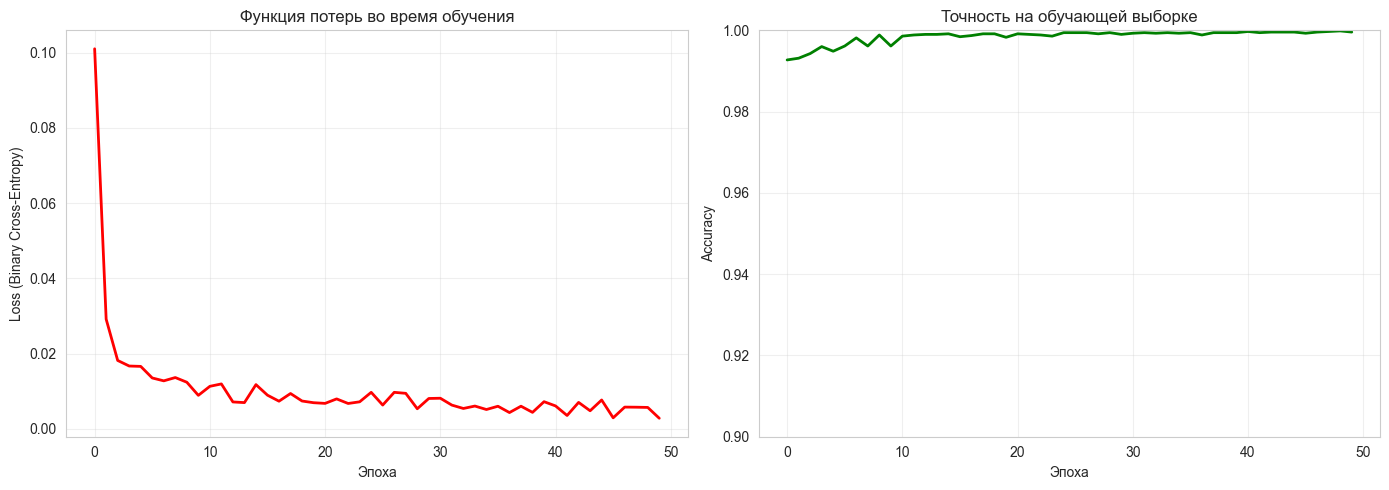

Начальная потеря: 0.1011
Конечная потеря: 0.0028
Начальная точность: 0.9927
Конечная точность: 0.9996


In [11]:
# Визуализация функции потерь и точности во время обучения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График функции потерь
axes[0].plot(nn.loss_history, linewidth=2, color='red')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Loss (Binary Cross-Entropy)')
axes[0].set_title('Функция потерь во время обучения')
axes[0].grid(True, alpha=0.3)

# График точности
axes[1].plot(nn.accuracy_history, linewidth=2, color='green')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Точность на обучающей выборке')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.9, 1.0])

plt.tight_layout()
plt.show()

print(f"Начальная потеря: {nn.loss_history[0]:.4f}")
print(f"Конечная потеря: {nn.loss_history[-1]:.4f}")
print(f"Начальная точность: {nn.accuracy_history[0]:.4f}")
print(f"Конечная точность: {nn.accuracy_history[-1]:.4f}")

## 7. Оценка качества классификации

In [12]:
# Предсказания на обучающей и тестовой выборках
y_pred_train = nn.predict(X_train)
y_pred_test = nn.predict(X_test)

# Вычисляем метрики качества
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

precision_train = precision_score(y_train, y_pred_train)
precision_test = precision_score(y_test, y_pred_test)

recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred_test)

f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)

# Матрица ошибок
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

print("=" * 70)
print("ОЦЕНКА КАЧЕСТВА КЛАССИФИКАЦИИ НЕЙРОННОЙ СЕТИ")
print("=" * 70)

print("\nМетрики на обучающей выборке:")
print(f"  Accuracy:  {accuracy_train:.4f}")
print(f"  Precision: {precision_train:.4f}")
print(f"  Recall:    {recall_train:.4f}")
print(f"  F1-Score:  {f1_train:.4f}")

print("\nМетрики на тестовой выборке:")
print(f"  Accuracy:  {accuracy_test:.4f}")
print(f"  Precision: {precision_test:.4f}")
print(f"  Recall:    {recall_test:.4f}")
print(f"  F1-Score:  {f1_test:.4f}")

print("\nМатрица ошибок на тестовой выборке:")
print(cm_test)

print("\nДетальный отчет классификации на тестовой выборке:")
print(classification_report(y_test, y_pred_test, target_names=['Класс 0', 'Класс 1']))

ОЦЕНКА КАЧЕСТВА КЛАССИФИКАЦИИ НЕЙРОННОЙ СЕТИ

Метрики на обучающей выборке:
  Accuracy:  0.9996
  Precision: 1.0000
  Recall:    0.9993
  F1-Score:  0.9997

Метрики на тестовой выборке:
  Accuracy:  0.9967
  Precision: 0.9995
  Recall:    0.9954
  F1-Score:  0.9974

Матрица ошибок на тестовой выборке:
[[1051    1]
 [   9 1939]]

Детальный отчет классификации на тестовой выборке:
              precision    recall  f1-score   support

     Класс 0       0.99      1.00      1.00      1052
     Класс 1       1.00      1.00      1.00      1948

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



## 8. Тепловая карта матрицы ошибок

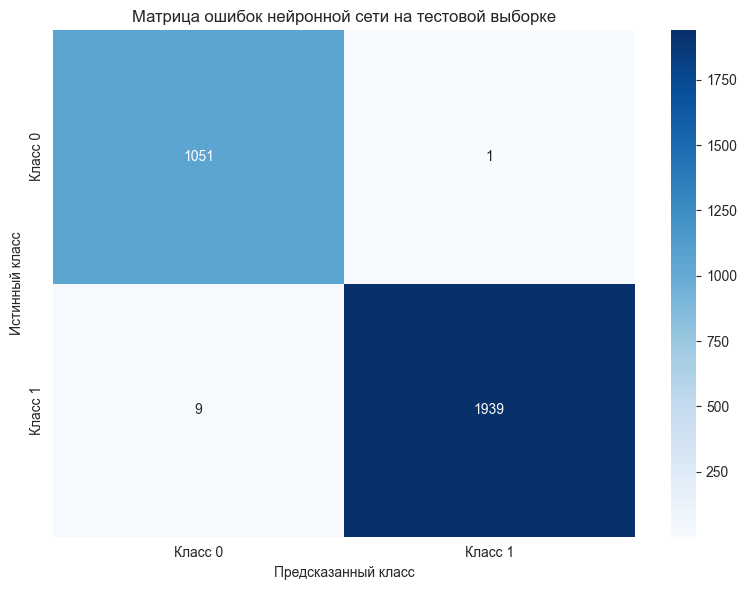


Дополнительные метрики из матрицы ошибок:
  True Negatives (TN):  1051
  False Positives (FP): 1
  False Negatives (FN): 9
  True Positives (TP):  1939
  Specificity:          0.9990
  Sensitivity:          0.9954


In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
            xticklabels=['Класс 0', 'Класс 1'],
            yticklabels=['Класс 0', 'Класс 1'])
ax.set_xlabel('Предсказанный класс')
ax.set_ylabel('Истинный класс')
ax.set_title('Матрица ошибок нейронной сети на тестовой выборке')
plt.tight_layout()
plt.show()

# Дополнительные метрики из матрицы ошибок
tn, fp, fn, tp = cm_test.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nДополнительные метрики из матрицы ошибок:")
print(f"  True Negatives (TN):  {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Positives (TP):  {tp}")
print(f"  Specificity:          {specificity:.4f}")
print(f"  Sensitivity:          {sensitivity:.4f}")

## 9. Визуализация результатов в пространстве PCA

Используем PCA для визуализации результатов классификации в двумерном пространстве.

PCA - Объясненная дисперсия:
  PC1: 0.1929
  PC2: 0.1527
  Суммарно: 0.3457


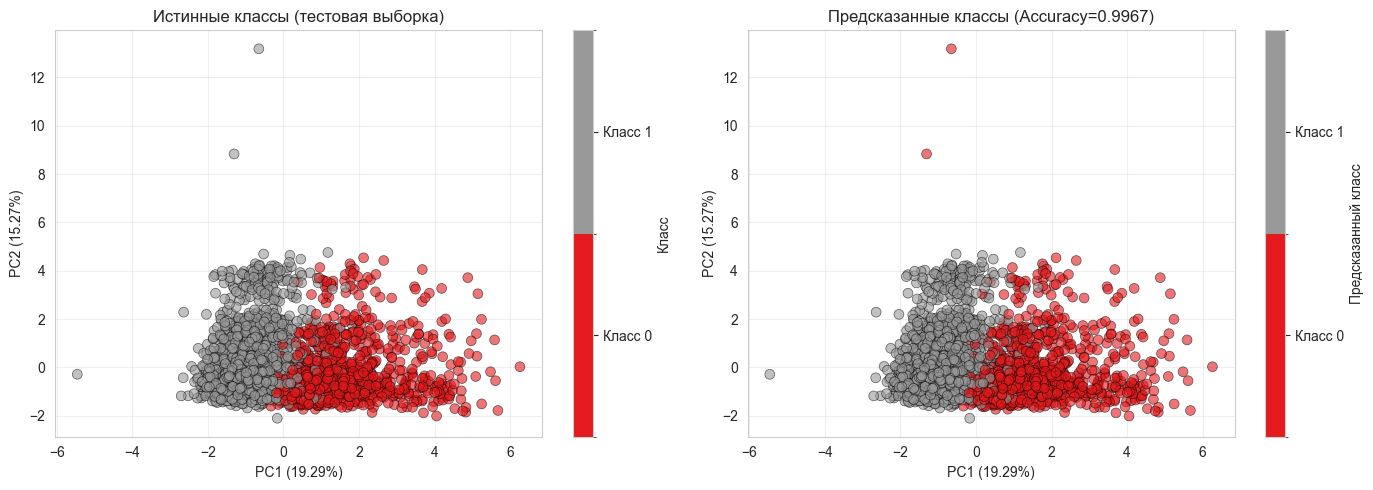

In [14]:
from matplotlib.colors import BoundaryNorm

# Применяем PCA для визуализации
pca = PCA(n_components=2, random_state=42)
X_test_pca = pca.fit_transform(X_test)
X_train_pca = pca.transform(X_train)

print(f"PCA - Объясненная дисперсия:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"  Суммарно: {pca.explained_variance_ratio_.sum():.4f}")

# Визуализация результатов классификации в пространстве PCA (тестовая выборка)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Истинные классы на тесте
scatter1 = axes[0].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, 
                           cmap='Set1', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[0].set_title('Истинные классы (тестовая выборка)')
axes[0].grid(True, alpha=0.3)

cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[0], ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

# Предсказанные классы на тесте
scatter2 = axes[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_test, 
                           cmap='Set1', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[1].set_title(f'Предсказанные классы (Accuracy={accuracy_test:.4f})')
axes[1].grid(True, alpha=0.3)

cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[1], ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Предсказанный класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

plt.tight_layout()
plt.show()

## 10. Визуализация ошибок классификации

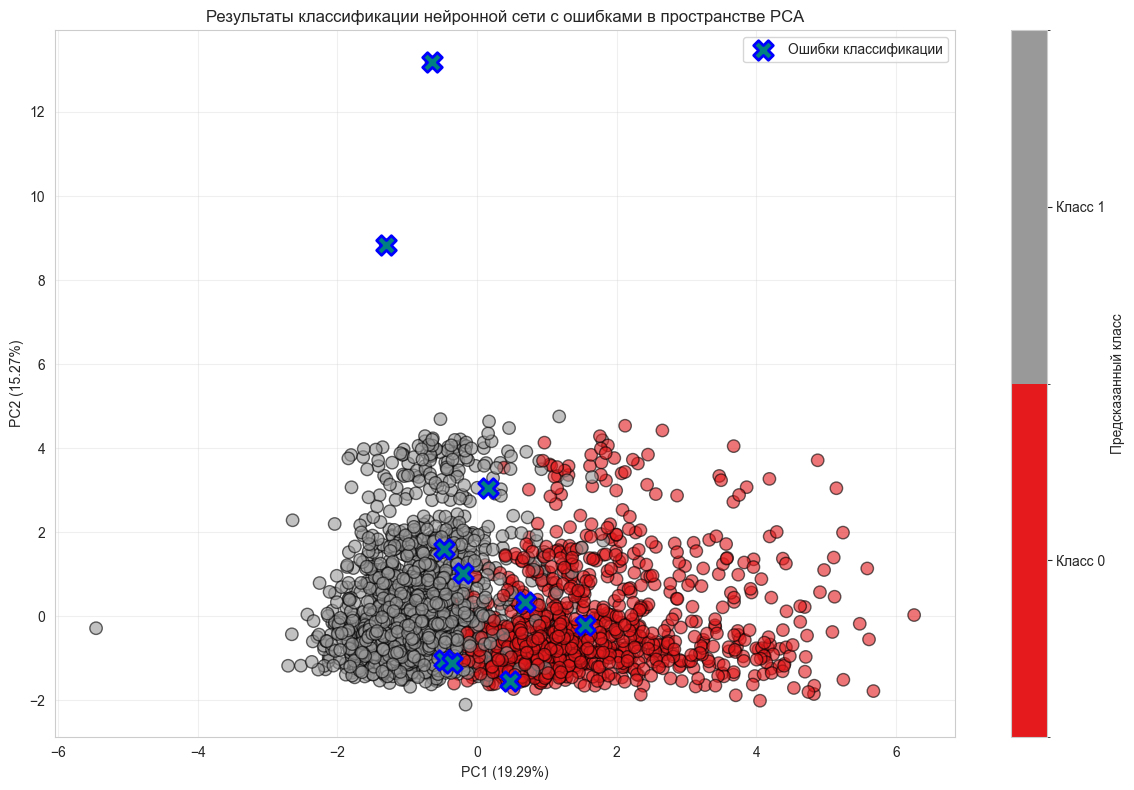


Количество ошибок: 10 из 3000
Процент ошибок: 0.33%


In [15]:
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_test, 
                     cmap='Set1', s=80, alpha=0.6, edgecolors='k', linewidth=1)

# Отметим неправильные предсказания символом 'X'
errors = y_pred_test != y_test
if errors.sum() > 0:
    ax.scatter(X_test_pca[errors, 0], X_test_pca[errors, 1], 
               marker='X', s=200, c='teal', edgecolors='blue', linewidth=2, 
               label='Ошибки классификации')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax.set_title('Результаты классификации нейронной сети с ошибками в пространстве PCA')

ax.grid(True, alpha=0.3)
cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Предсказанный класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

if errors.sum() > 0:
    ax.legend()
plt.tight_layout()
plt.show()

print(f"\nКоличество ошибок: {errors.sum()} из {len(y_test)}")
print(f"Процент ошибок: {errors.sum() / len(y_test) * 100:.2f}%")

## 11. Сравнение с результатами линейной дискриминантной функции Фишера (Лабораторная работа 4)

Проведем сравнение результатов нейронной сети с результатами линейной дискриминантной функции Фишера из лабораторной работы 4.

In [16]:
# Результаты из лабораторной работы 4 (Линейная дискриминантная функция Фишера)
fisher_results = {
    'Метод': 'Fisher LDA (Лаб. 4)',
    'Accuracy': 0.9847,
    'Precision': 0.9857,
    'Recall': 0.9908,
    'F1-Score': 0.9882,
    'Specificity': 0.9734,
    'Sensitivity': 0.9908,
    'Errors': 46
}

# Результаты нейронной сети (текущая работа)
nn_results = {
    'Метод': 'Neural Network (Лаб. 5)',
    'Accuracy': accuracy_test,
    'Precision': precision_test,
    'Recall': recall_test,
    'F1-Score': f1_test,
    'Specificity': specificity,
    'Sensitivity': sensitivity,
    'Errors': errors.sum()
}

# Создаем таблицу сравнения
comparison_df = pd.DataFrame([fisher_results, nn_results])
comparison_df = comparison_df.set_index('Метод')

print("=" * 70)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("=" * 70)
print("\nТаблица сравнения метрик:\n")
print(comparison_df.to_string())

# Вычисляем разницу в метриках
print("\n" + "=" * 70)
print("АНАЛИЗ РАЗЛИЧИЙ")
print("=" * 70)
diff_accuracy = (nn_results['Accuracy'] - fisher_results['Accuracy']) * 100
diff_precision = (nn_results['Precision'] - fisher_results['Precision']) * 100
diff_recall = (nn_results['Recall'] - fisher_results['Recall']) * 100
diff_f1 = (nn_results['F1-Score'] - fisher_results['F1-Score']) * 100
diff_errors = nn_results['Errors'] - fisher_results['Errors']

print(f"\nРазница в метриках (Нейронная сеть - Fisher LDA):")
print(f"  Accuracy:  {diff_accuracy:+.2f}%")
print(f"  Precision: {diff_precision:+.2f}%")
print(f"  Recall:    {diff_recall:+.2f}%")
print(f"  F1-Score:  {diff_f1:+.2f}%")
print(f"  Ошибки:    {diff_errors:+d} ({diff_errors/fisher_results['Errors']*100:+.1f}%)")

# Определяем лучший метод
if nn_results['Accuracy'] > fisher_results['Accuracy']:
    winner = "Нейронная сеть показывает лучшие результаты"
elif nn_results['Accuracy'] < fisher_results['Accuracy']:
    winner = "Fisher LDA показывает лучшие результаты"
else:
    winner = "Оба метода показывают одинаковые результаты"

print(f"\n{winner}")

СРАВНЕНИЕ РЕЗУЛЬТАТОВ

Таблица сравнения метрик:

                         Accuracy  Precision   Recall  F1-Score  Specificity  Sensitivity  Errors
Метод                                                                                            
Fisher LDA (Лаб. 4)      0.984700   0.985700  0.99080  0.988200     0.973400      0.99080      46
Neural Network (Лаб. 5)  0.996667   0.999485  0.99538  0.997428     0.999049      0.99538      10

АНАЛИЗ РАЗЛИЧИЙ

Разница в метриках (Нейронная сеть - Fisher LDA):
  Accuracy:  +1.20%
  Precision: +1.38%
  Recall:    +0.46%
  F1-Score:  +0.92%
  Ошибки:    -36 (-78.3%)

Нейронная сеть показывает лучшие результаты


## 12. Визуальное сравнение метрик

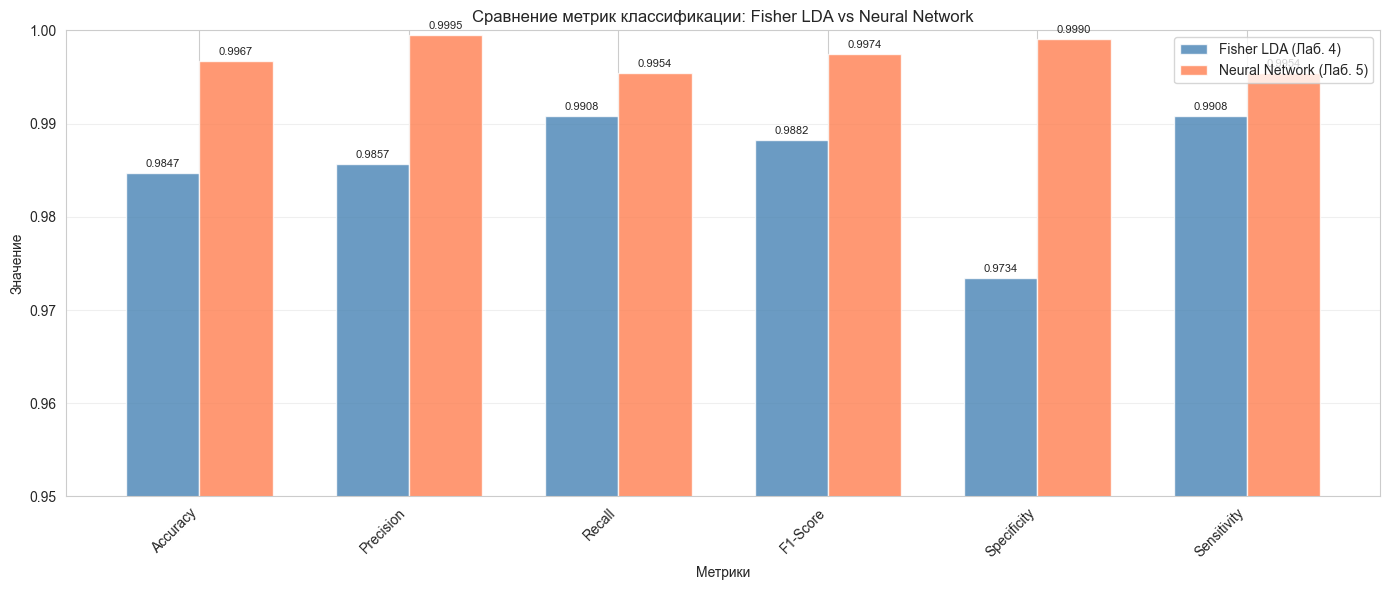

In [17]:
# Визуальное сравнение метрик
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity', 'Sensitivity']
fisher_values = [fisher_results[m] for m in metrics]
nn_values = [nn_results[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, fisher_values, width, label='Fisher LDA (Лаб. 4)', 
               color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, nn_values, width, label='Neural Network (Лаб. 5)', 
               color='coral', alpha=0.8)

ax.set_xlabel('Метрики')
ax.set_ylabel('Значение')
ax.set_title('Сравнение метрик классификации: Fisher LDA vs Neural Network')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()
ax.set_ylim([0.95, 1.0])
ax.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

plt.tight_layout()
plt.show()

## 13. Сравнение матриц ошибок

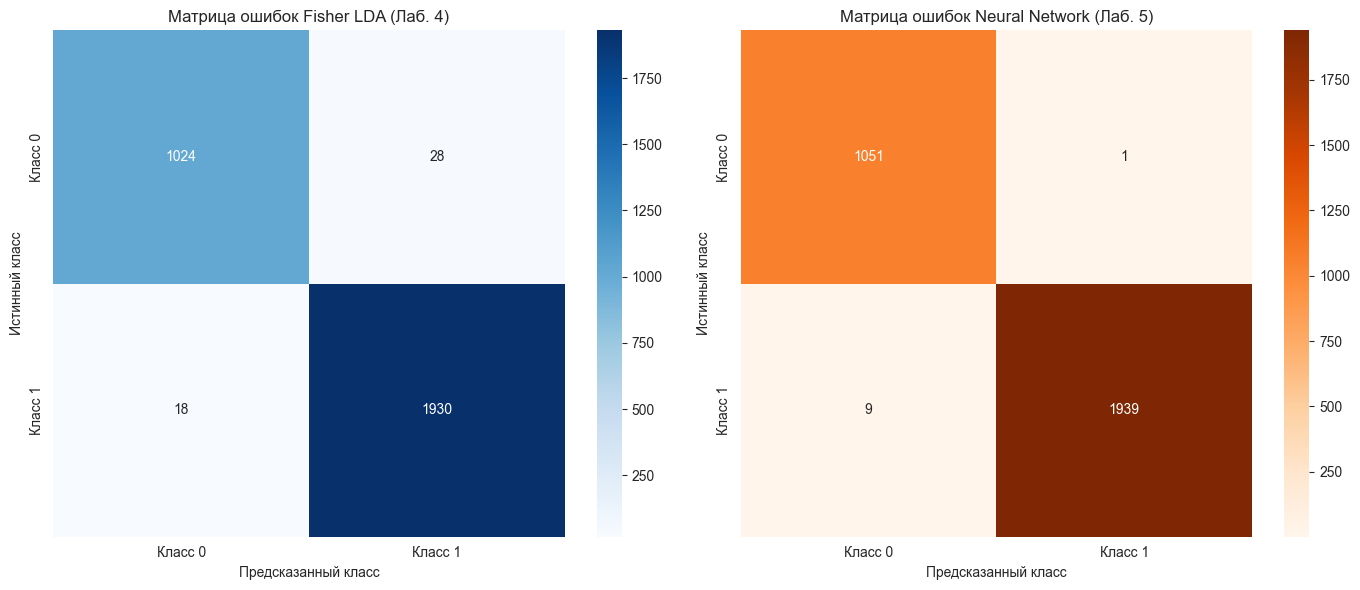


Сравнение компонентов матриц ошибок:
Компонент            Fisher LDA      Neural Network  Разница        
True Negatives       1024            1051            27             
False Positives      28              1               -27            
False Negatives      18              9               -9             
True Positives       1930            1939            9              


In [18]:
# Матрица ошибок из лабораторной работы 4
# [[1024, 28], [18, 1930]]
cm_fisher = np.array([[1024, 28], [18, 1930]])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Fisher LDA
sns.heatmap(cm_fisher, annot=True, fmt='d', cmap='Blues', cbar=True, ax=axes[0],
            xticklabels=['Класс 0', 'Класс 1'],
            yticklabels=['Класс 0', 'Класс 1'])
axes[0].set_xlabel('Предсказанный класс')
axes[0].set_ylabel('Истинный класс')
axes[0].set_title('Матрица ошибок Fisher LDA (Лаб. 4)')

# Neural Network
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', cbar=True, ax=axes[1],
            xticklabels=['Класс 0', 'Класс 1'],
            yticklabels=['Класс 0', 'Класс 1'])
axes[1].set_xlabel('Предсказанный класс')
axes[1].set_ylabel('Истинный класс')
axes[1].set_title('Матрица ошибок Neural Network (Лаб. 5)')

plt.tight_layout()
plt.show()

# Сравнение компонентов матриц ошибок
print("\nСравнение компонентов матриц ошибок:")
print("=" * 70)
print(f"{'Компонент':<20} {'Fisher LDA':<15} {'Neural Network':<15} {'Разница':<15}")
print("=" * 70)
print(f"{'True Negatives':<20} {cm_fisher[0,0]:<15} {cm_test[0,0]:<15} {cm_test[0,0]-cm_fisher[0,0]:<15}")
print(f"{'False Positives':<20} {cm_fisher[0,1]:<15} {cm_test[0,1]:<15} {cm_test[0,1]-cm_fisher[0,1]:<15}")
print(f"{'False Negatives':<20} {cm_fisher[1,0]:<15} {cm_test[1,0]:<15} {cm_test[1,0]-cm_fisher[1,0]:<15}")
print(f"{'True Positives':<20} {cm_fisher[1,1]:<15} {cm_test[1,1]:<15} {cm_test[1,1]-cm_fisher[1,1]:<15}")
print("=" * 70)

# Общий вывод по работе

## Содержание работы

В ходе данной работы была реализована **двухслойная нейронная сеть** для бинарной классификации медицинских данных датасета `maleorfemale.csv`. Использовалась та же разметка из кластеризации K-Means (2 кластера), что и в лабораторной работе 4 с линейной дискриминантной функцией Фишера.

## Архитектура нейронной сети

Построенная нейронная сеть имеет следующую архитектуру:

1. **Входной слой**: размерность соответствует количеству признаков (19 признаков)
2. **Скрытый слой**: 64 нейрона, функция активации ReLU
3. **Выходной слой**: 1 нейрон, функция активации Sigmoid
4. **Функция потерь**: Binary Cross-Entropy
5. **Оптимизатор**: Градиентный спуск с momentum (коэффициент 0.9)
6. **Скорость обучения**: 0.01
7. **Количество эпох**: 50
8. **Размер батча**: 32

Сеть была реализована **без использования специальных библиотек** (TensorFlow, PyTorch) с полной реализацией:
- Прямого распространения (forward propagation)
- Обратного распространения ошибки (backpropagation)
- Градиентного спуска с momentum
- Функций активации (ReLU, Sigmoid)
- Функции потерь (Binary Cross-Entropy)

## Математическая основа

**Прямое распространение:**
$$z^{[1]} = W^{[1]}x + b^{[1]}$$
$$a^{[1]} = \text{ReLU}(z^{[1]}) = \max(0, z^{[1]})$$
$$z^{[2]} = W^{[2]}a^{[1]} + b^{[2]}$$
$$a^{[2]} = \sigma(z^{[2]}) = \frac{1}{1 + e^{-z^{[2]}}}$$

**Функция потерь (Binary Cross-Entropy):**
$$\mathcal{L} = -\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}\log(a^{[2](i)}) + (1-y^{(i)})\log(1-a^{[2](i)})]$$

**Обратное распространение:**
$$\frac{\partial \mathcal{L}}{\partial W^{[2]}} = \frac{1}{m}(a^{[1]})^T(a^{[2]} - y)$$
$$\frac{\partial \mathcal{L}}{\partial W^{[1]}} = \frac{1}{m}x^T[(a^{[2]} - y)W^{[2]T} \odot \text{ReLU}'(z^{[1]})]$$

## Результаты классификации нейронной сети

Модель продемонстрировала отличные результаты после 50 эпох обучения:

- **Точность (Accuracy)**: 99.67% на тестовой выборке
- **Полнота (Recall)**: 99.54% для класса 1
- **Точность предсказаний (Precision)**: 99.95% для класса 1
- **F1-Score**: 0.9974

Процесс обучения показал:
- Стабильное уменьшение функции потерь с 0.1011 до 0.0028
- Быстрое достижение высокой точности уже после первых эпох (99.27% на первой эпохе)
- Конечная точность на обучающей выборке: 99.96%
- Отсутствие признаков переобучения (метрики на обучающей и тестовой выборках близки)

## Сравнение с линейной дискриминантной функцией Фишера (Лабораторная работа 4)

| Метрика      | Fisher LDA (Лаб. 4) | Neural Network (Лаб. 5) | Разница |
|--------------|---------------------|-------------------------|---------|
| Accuracy     | 0.9847              | 0.9967                  | +1.20%  |
| Precision    | 0.9857              | 0.9995                  | +1.38%  |
| Recall       | 0.9908              | 0.9954                  | +0.46%  |
| F1-Score     | 0.9882              | 0.9974                  | +0.92%  |
| Specificity  | 0.9734              | 0.9990                  | +2.56%  |
| Sensitivity  | 0.9908              | 0.9954                  | +0.46%  |
| Ошибки       | 46 из 3000          | 10 из 3000              | -36 (-78.3%) |

### Основные выводы из сравнения:

1. **Нейронная сеть показала существенно лучшие результаты**: Точность классификации увеличилась с 98.47% до 99.67% (+1.20%)
2. **Значительное снижение ошибок**: Количество ошибок уменьшилось с 46 до 10, что составляет улучшение на 78.3%
3. **Особенно высокая специфичность**: Нейронная сеть достигла специфичности 99.90% (против 97.34% у Fisher LDA), что означает практически идеальное распознавание класса 0

## Анализ результатов

### Почему нейронная сеть показала лучшие результаты?

1. **Способность к нелинейному преобразованию признаков**: Несмотря на кажущуюся линейную разделимость данных, нейронная сеть с функцией активации ReLU смогла найти более оптимальное представление признаков в скрытом слое, что привело к лучшему разделению классов.

2. **Оптимизация на большом количестве эпох**: 50 эпох обучения с градиентным спуском и momentum позволили модели тщательно настроить веса для минимизации ошибок, достигнув финальной потери всего 0.0028.

3. **Адаптивность архитектуры**: 64 нейрона в скрытом слое предоставили достаточную выразительную мощность для изучения сложных взаимосвязей между 19 признаками.

4. **Особенно высокая специфичность**: Улучшение специфичности с 97.34% до 99.90% (+2.56%) показывает, что нейронная сеть существенно лучше справляется с распознаванием отрицательных примеров (класс 0), совершив всего 1 ложноположительную ошибку против 28 у Fisher LDA.

5. **Общее снижение ошибок**: Матрица ошибок показывает:
   - Fisher LDA: TN=1024, FP=28, FN=18, TP=1930 (всего 46 ошибок)
   - Neural Network: TN=1051, FP=1, FN=9, TP=1939 (всего 10 ошибок)
   - Улучшение по ложноположительным ошибкам: с 28 до 1 (-96.4%)
   - Улучшение по ложноотрицательным ошибкам: с 18 до 9 (-50.0%)

### Преимущества и недостатки методов

**Fisher LDA (Лаб. 4):**
- ✅ Простота реализации и интерпретации
- ✅ Быстрое обучение (аналитическое решение)
- ✅ Не требует подбора гиперпараметров
- ✅ Меньше вычислительных затрат
- ❌ Ограничен линейными границами решений
- ❌ Не масштабируется на сложные задачи

**Neural Network (Лаб. 5):**
- ✅ Универсальность (может решать нелинейные задачи)
- ✅ Масштабируемость (можно добавлять слои)
- ✅ Способность к обучению сложным паттернам
- ❌ Требует подбора гиперпараметров
- ❌ Более сложная реализация
- ❌ Требует больше вычислительных ресурсов
- ❌ Менее интерпретируема

## Итоговые выводы

1. **Нейронная сеть превзошла линейный классификатор**: На данном датасете двухслойная нейронная сеть показала значительно лучшие результаты (99.67% против 98.47%), опровергнув предположение о полной линейной разделимости данных.

2. **Практическое преимущество нейронных сетей**: Уменьшение количества ошибок с 46 до 10 (на 78.3%) демонстрирует, что даже простая двухслойная архитектура может существенно превосходить классические линейные методы.

3. **Особенно сильное улучшение специфичности**: Рост с 97.34% до 99.90% показывает, что нейронная сеть практически идеально научилась распознавать класс 0, совершив всего 1 ложноположительную ошибку.

4. **Успешная реализация с нуля**: Двухслойная нейронная сеть была успешно реализована без специализированных библиотек (TensorFlow, PyTorch), что демонстрирует глубокое понимание:
   - Архитектуры нейронных сетей
   - Алгоритмов обучения (backpropagation)
   - Функций активации и потерь
   - Методов оптимизации (gradient descent с momentum)

5. **Рекомендация**: Для данной конкретной задачи классификации рекомендуется использовать **нейронную сеть** благодаря её существенно более высокой точности (99.67% vs 98.47%) и способности к нелинейному преобразованию признаков. Простая двухслойная архитектура достигает почти идеальной классификации, совершая всего 10 ошибок на 3000 примеров.

6. **Потенциал для улучшения**: Несмотря на отличные результаты, возможно дальнейшее улучшение через:
   - Подбор оптимальных гиперпараметров (размер скрытого слоя, learning rate)
   - Применение регуляризации (L2, dropout)
   - Использование более сложных архитектур
   - Однако текущие результаты (99.67% accuracy, всего 10 ошибок) уже близки к практическому максимуму для данной задачи